# Geneformer gene embeddings extraction and building a gene co-expression/regulation network (GRN)
Here we show how to extract gene embeddings from the pre-trained Geneformer 10M model, and how to build a gene co-expression network from gene embeddings for selected genes.

The single cell sequencing data set is from CellxGene, the same as used in the [cell type annotation tutorial](geneformer-celltype-classification.ipynb). The gene co-expression network is adapted from a [scGPT tutorial](https://scgpt.readthedocs.io/en/latest/tutorial_grn.html).

First, we download the dataset from czi that we are interested in, and then create the requisite sc_memmap dataset object. Then we extract gene embeddings using infer_geneformer. After that, we can get the gene embedding values to build gene co-expression network based on cosine similarity.

In [20]:
# NBVAL_CHECK_OUTPUT
import cellxgene_census


CENSUS_VERSION = "2023-12-15"
with cellxgene_census.open_soma(census_version=CENSUS_VERSION) as census:
    adata = cellxgene_census.get_anndata(
        census,
        "Homo sapiens",
        obs_value_filter='dataset_id=="8e47ed12-c658-4252-b126-381df8d52a3d"',
    )
uq_cells = sorted(adata.obs["cell_type"].unique().tolist())
uq_cells

['B cell',
 'CD4-positive, alpha-beta T cell',
 'CD8-positive, alpha-beta T cell',
 'IgA plasma cell',
 'IgG plasma cell',
 'M cell of gut',
 'T follicular helper cell',
 'activated CD4-positive, alpha-beta T cell, human',
 'conventional dendritic cell',
 'dendritic cell, human',
 'endothelial cell of artery',
 'endothelial cell of lymphatic vessel',
 'enterocyte',
 'enteroendocrine cell',
 'fibroblast',
 'gamma-delta T cell',
 'glial cell',
 'intestinal crypt stem cell',
 'intestinal tuft cell',
 'intestine goblet cell',
 'mast cell',
 'memory B cell',
 'monocyte',
 'myeloid cell',
 'myofibroblast cell',
 'pericyte',
 'plasma cell',
 'plasmacytoid dendritic cell',
 'regulatory T cell',
 'transit amplifying cell',
 'vein endothelial cell']

In [21]:
# NBVAL_CHECK_OUTPUT
import random
from contextlib import contextmanager


@contextmanager
def random_seed(seed: int):
    """Context manager to set the random seed for reproducibility."""
    state = random.getstate()
    random.seed(seed)
    try:
        yield
    finally:
        # Go back to previous state
        random.setstate(state)


with random_seed(32):
    indices = list(range(len(adata)))
    random.shuffle(indices)

micro_batch_size: int = 32
num_steps: int = 256
selection = sorted(indices[: micro_batch_size * num_steps])
# NOTE: there's a current constraint that predict_step needs to be a function of micro-batch-size.
#  this is something we are working on fixing. A quick hack is to set micro-batch-size=1, but this is
#  slow. In this notebook we are going to use mbs=32 and subsample the anndata.
adata = adata[selection].copy()  # so it's not a view
adata.shape

(8192, 60664)

In [22]:
import shutil

from bionemo.core import BIONEMO_CACHE_DIR


cleanup: bool = True
notebook_workdir = BIONEMO_CACHE_DIR / "notebook_tutorials" / "geneformer_geneembeddings-GRN"
if cleanup and notebook_workdir.exists():
    shutil.rmtree(notebook_workdir)
notebook_workdir.mkdir(parents=True, exist_ok=True)
input_dir = notebook_workdir / "celltype-bench-dataset-input"
data_dir = notebook_workdir / "celltype-bench-dataset"
input_dir.mkdir(parents=True, exist_ok=True)
h5ad_outfile = input_dir / "hs-celltype-bench.h5ad"
adata.write_h5ad(h5ad_outfile)

Your results are saved in this directory.

In [23]:
print(notebook_workdir)

/root/.cache/bionemo/notebook_tutorials/geneformer_geneembeddings-GRN


## Create the scmemmap object, check outputs

In [24]:
!convert_h5ad_to_scdl --data-path {input_dir} --save-path {data_dir}

Importantly, the `.npy` files are used by BioNeMo dataset object. `features.csv` contains the metadata requested, in this case cell_type. It's important that the output of our model has the same order as `features.csv`, as this contains the labels used in the following benchmark.

In [25]:
# NBVAL_CHECK_OUTPUT
from glob import glob


files = sorted(
    [f.split("/")[-1] for f in glob(str(data_dir / "*"))]
)  # strip off the directory name and sort for the test
files

['col_ptr.npy',
 'data.npy',
 'features',
 'metadata.json',
 'row_ptr.npy',
 'version.json']

Import geneformer-10M model for infer geneformer to retrieve gene embeddings

In [26]:
from bionemo.core.data.load import load


# 10m checkpoint
geneformer_10m = load("geneformer/10M_240530:2.0")

In [27]:
result_path_10m = notebook_workdir / "results_10m.pt"

## Execute inference
We run inference on the Geneformer model downloaded by `load(...)` function in a previous cell. We have a one-off inference script for geneformer that is installed as part of the `bionemo-geneformer` package. See the `pyproject.toml` in the source directory if you are curious or want to use this as a template to make your own inference scripts. This script should work for any `sc_memmap` converted geneformer dataset, and geneformer bionemo2 model checkpoint though.

In order to extract gene embeddings, you also need to specify --include-input-ids and --include-hiddens

In [28]:
!infer_geneformer \
    --data-dir {data_dir} \
    --checkpoint-path {geneformer_10m} \
    --results-path {result_path_10m} \
    --micro-batch-size {micro_batch_size} \
    --seq-len 2048 \
    --num-dataset-workers 10 \
    --num-gpus 1 \
    --include-input-ids \
    --include-hiddens \
    --include-gene-embeddings

Could not find the bitsandbytes CUDA binary at PosixPath('/usr/local/lib/python3.12/dist-packages/bitsandbytes/libbitsandbytes_cuda129.so')
The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
[NeMo W 2025-06-02 14:12:30 nemo_logging:405] Tokenizer vocab file: /root/.cache/bionemo/d8e3ea569bc43768c24aa651aff77722df202078415528497c22394046b08cc3-singlecell-scdltestdata-20241203.tar.gz.untar/cellxgene_2023-12-15_small_processed_scdl/train/geneformer.vocab already exists. Overwriting...
[NeMo I 2025-06-02 14:12:30 nemo_logging:393] No checksum provided, filename exists. Assuming it is complete.
[NeMo I 2025-06-02 14:12:30 nemo_logging:393] Resource already exists, skipping download: https://huggingface.co/ctheodoris/Geneformer/resolve/main/geneformer/gene_dictionaries_30m/gene_name_id_dict_gc30M.pkl?download=true
[NeMo I 2025-06-02 14:12:30 nemo_logging:393] No checksum provided, filename exis

## Load gene embeddings
Load gene embeddings and add gene names. If executed correctly, you should be able to see gene_embeddings in predictions.keys().

In [29]:
import torch


predictions = torch.load(result_path_10m / "predictions__rank_0.pt", weights_only=False)

print(predictions.keys())

dict_keys(['token_logits', 'binary_logits', 'hidden_states', 'input_ids', 'embeddings', 'gene_embeddings', 'gene_counts', 'ensembl_IDs', 'gene_symbols'])


In [30]:
predictions["gene_embeddings"].keys()

dict_keys([8525, 17317, 14183, 18632, 18594, 8662, 5215, 2912, 6864, 3085, 17546, 13275, 6684, 9948, 3144, 12033, 8211, 4723, 17324, 6209, 14128, 7614, 8568, 11035, 3667, 6430, 2340, 13061, 8208, 20337, 10604, 5796, 4040, 10416, 11788, 5823, 10642, 17980, 10822, 8677, 10251, 16983, 8933, 8060, 11322, 17718, 2288, 3042, 460, 1617, 4831, 972, 245, 4390, 16740, 19478, 20002, 11546, 8700, 16300, 4777, 8922, 6299, 4481, 16916, 7382, 6422, 8956, 8459, 272, 9218, 14986, 17054, 2386, 3925, 4550, 5337, 14172, 7058, 5541, 2260, 10363, 7505, 19826, 3505, 5040, 12431, 8259, 3478, 6241, 3039, 6767, 11051, 8433, 14040, 22565, 5850, 1473, 21022, 15279, 7160, 12079, 7830, 2990, 255, 14959, 21179, 3655, 19904, 461, 4842, 625, 13919, 6153, 16391, 6063, 12575, 1150, 8839, 9503, 10975, 6739, 3547, 13774, 8234, 11411, 7728, 9145, 8168, 14682, 13757, 855, 8011, 5549, 4353, 17227, 5909, 11555, 15334, 13040, 1132, 7355, 2654, 4340, 6061, 570, 2165, 10236, 17074, 1170, 12246, 18585, 1528, 3194, 1914, 11999, 30

Use gene symbols as the index


In [31]:
import pandas as pd


gene_embeddings = torch.stack(list(predictions["gene_embeddings"].values())).to(torch.float32).cpu().numpy()
gene_embeddings_df = pd.DataFrame(gene_embeddings, index=predictions["gene_symbols"].values())
gene_embeddings_df

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
NBEAL1,0.042725,0.167969,-0.043945,-0.061523,-0.091309,0.021484,0.083984,-0.083984,0.047607,0.167969,...,0.077148,-0.086426,-0.015320,0.167969,0.083984,-0.047852,-0.128906,0.083984,-0.084473,-0.146484
RPL39,0.066406,-0.132812,-0.033203,-0.033203,0.132812,0.066406,-0.066406,0.037109,0.066406,-0.066406,...,0.066406,-0.054932,0.033203,-0.016479,-0.034424,0.016602,-0.066406,0.034424,0.033203,0.033936
RPS27,0.104004,-0.127930,0.054443,0.063965,-0.029175,0.063965,0.018677,-0.066406,0.063965,-0.063965,...,-0.063965,0.106934,0.063965,0.035156,-0.046631,-0.032471,-0.085449,0.016479,-0.032227,0.032471
ZNF90,0.283203,0.281250,-0.071289,0.016357,-0.253906,-0.141602,0.092773,-0.143555,0.082031,0.265625,...,0.141602,0.141602,0.141602,0.143555,-0.102539,-0.072266,-0.153320,-0.141602,-0.070801,-0.141602
RPS29,0.056396,-0.125977,0.030640,-0.040771,0.032227,0.062988,-0.062988,-0.062988,-0.031494,0.062988,...,-0.062988,-0.056641,0.037842,0.062988,0.062988,-0.031494,-0.067871,-0.032227,-0.041016,-0.062988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
IGKV3D-7,1.156250,-0.281250,0.168945,-0.285156,-0.330078,-0.765625,1.062500,-0.002670,0.671875,1.140625,...,-0.163086,0.018066,-0.546875,0.925781,0.200195,-0.107422,-1.656250,-0.024292,0.287109,0.110840
FAM187B,-0.050293,-0.773438,0.032471,0.019775,-0.566406,1.203125,0.047607,0.476562,0.535156,2.000000,...,-0.898438,0.084961,1.265625,0.984375,0.859375,-0.601562,1.296875,0.281250,-0.234375,-0.177734
ATP2B3,0.855469,-0.335938,-0.427734,0.781250,-0.178711,-0.468750,0.164062,0.006195,0.208008,2.218750,...,-1.289062,-0.238281,0.019775,1.070312,0.498047,-0.408203,1.203125,1.398438,-0.625000,0.182617
ITIH1,0.058594,-1.820312,-0.376953,0.021240,-0.953125,0.507812,0.071289,0.714844,0.332031,2.421875,...,-0.347656,-0.419922,0.359375,1.078125,0.765625,-0.126953,0.796875,1.570312,-0.063965,0.675781


## Visualize network connectivity within desired gene program

The following tutorial is adapted from scGPT tutorial to show how to use gene embeddings to build gene co-expression network

In [32]:
CD_genes = ["LCK", "CD2", "LTB", "CD3E", "CD3G", "CD8B", "CD8A", "IL7R", "CD3D"]

In [33]:
import operator

from sklearn.metrics.pairwise import cosine_similarity


def compute_similarities(gene_embeddings_df, gene, subset=None):
    """
    Compute cosine similarities of the given gene against all others
    in the `gene_embeddings_df` DataFrame.

    Parameters:
    - gene (str): Gene symbol to compare against.
    - subset (list[str], optional): Optional list of target genes to compare to.

    Returns:
    - pd.DataFrame: DataFrame with columns ['Gene', 'Similarity'] sorted by similarity.
    """
    if gene not in gene_embeddings_df.index:
        return None

    embedding = gene_embeddings_df.loc[gene].values.reshape(1, -1)

    if subset:
        targets = list(set(gene_embeddings_df.index).intersection(set(subset)))
    else:
        targets = list(gene_embeddings_df.index)

    similarities = {}
    for target in targets:
        if target == gene:
            continue
        v = gene_embeddings_df.loc[target].values.reshape(1, -1)
        similarity = float(cosine_similarity(embedding, v)[0])
        similarities[target] = similarity

    # Sort by similarity (descending)
    sorted_distances = sorted(similarities.items(), key=operator.itemgetter(1), reverse=True)

    return pd.DataFrame(sorted_distances, columns=["Gene", "Similarity"])

In [34]:
import tqdm


# Initialize an empty list to collect DataFrames
df_list = []

gene_embeddings_df_CD = gene_embeddings_df.loc[gene_embeddings_df.index.intersection(CD_genes)]

for i in tqdm.tqdm(CD_genes):
    df = compute_similarities(gene_embeddings_df_CD, i)
    if df is not None:
        df["Gene1"] = i
        df_list.append(df)

# Concatenate all collected DataFrames
df_CD = pd.concat(df_list, ignore_index=True)

# Filter out self-similarity and sort
df_CD_sub = df_CD[df_CD["Similarity"] < 0.99].sort_values(by="Gene")

df_CD_sub

  0%|                                                                              | 0/9 [00:00<?, ?it/s]/tmp/ipykernel_177/2481566272.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  similarity = float(cosine_similarity(embedding, v)[0])
/tmp/ipykernel_177/2481566272.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  similarity = float(cosine_similarity(embedding, v)[0])
/tmp/ipykernel_177/2481566272.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  simil

,Gene,Similarity,Gene1
22,CD2,0.460666,LTB
46,CD2,0.515722,CD8B
31,CD2,0.495085,CD3E
62,CD2,0.486329,IL7R
39,CD2,0.316598,CD3G
...,...,...,...
54,LTB,0.515988,CD8A
45,LTB,0.572584,CD8B
38,LTB,0.371931,CD3G
61,LTB,0.542769,IL7R


In [35]:
import matplotlib.pyplot as plt
import networkx as nx

In [36]:
# Creates a graph from the cosine similarity network
input_node_weights = [(row["Gene"], row["Gene1"], round(row["Similarity"], 2)) for i, row in df_CD_sub.iterrows()]
G = nx.Graph()
G.add_weighted_edges_from(input_node_weights)

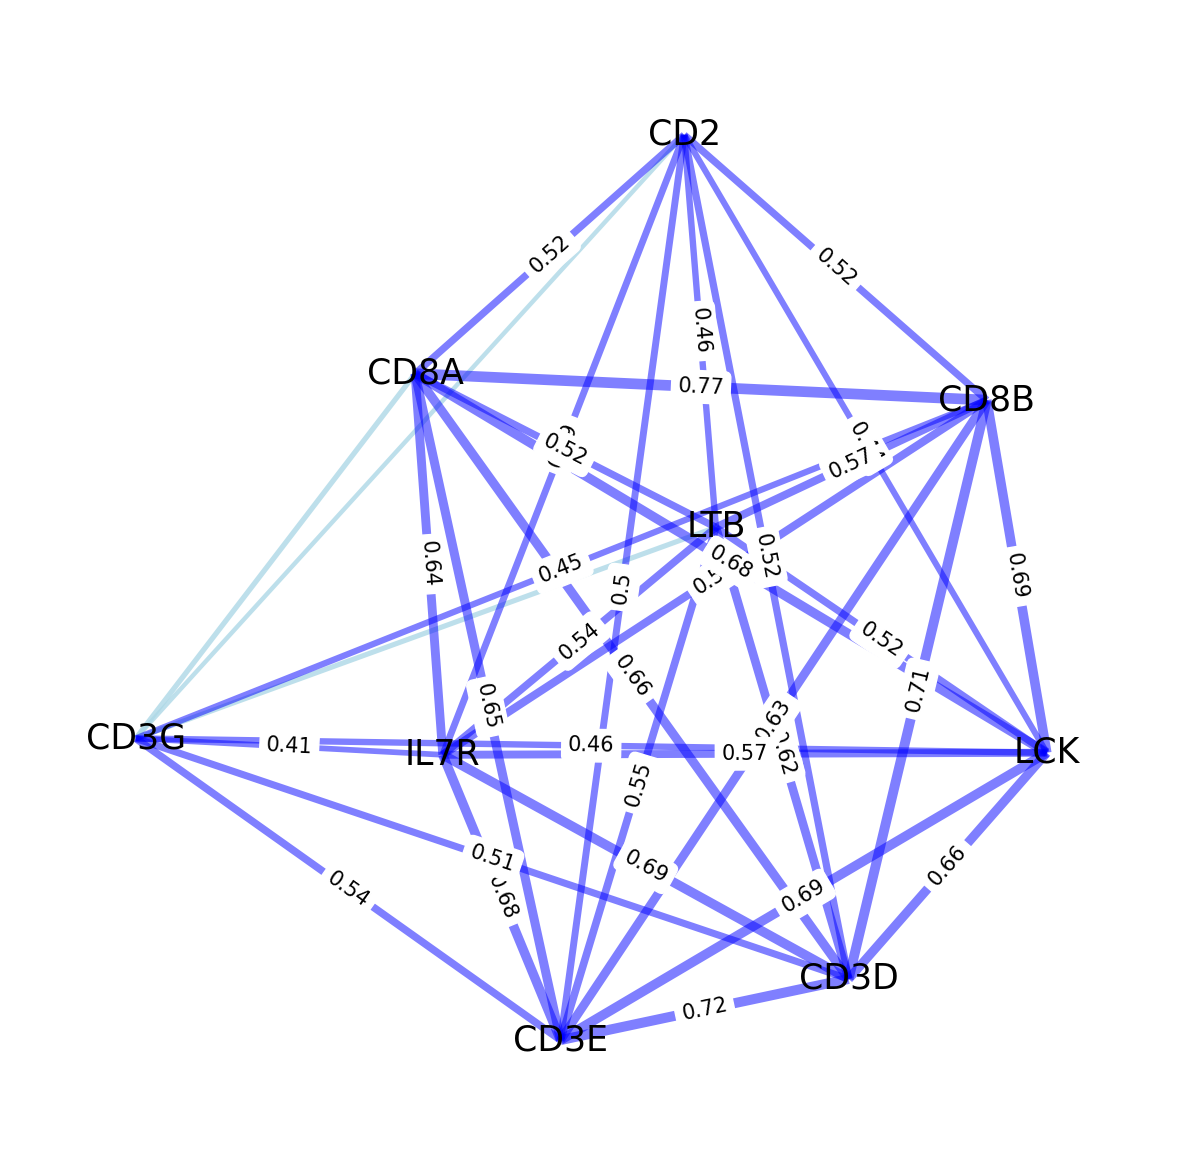

In [37]:
# Plot the cosine similarity network; strong edges (> select threshold) are highlighted
thresh = 0.4
plt.figure(figsize=(15, 15))
widths = nx.get_edge_attributes(G, "weight")

elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > thresh]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= thresh]

pos = nx.spring_layout(G, k=0.4, iterations=15, seed=3)

width_large = {}
width_small = {}
for i, v in enumerate(list(widths.values())):
    if v > thresh:
        width_large[list(widths.keys())[i]] = v * 10
    else:
        width_small[list(widths.keys())[i]] = max(v, 0) * 10

nx.draw_networkx_edges(
    G, pos, edgelist=width_small.keys(), width=list(width_small.values()), edge_color="lightblue", alpha=0.8
)
nx.draw_networkx_edges(
    G,
    pos,
    edgelist=width_large.keys(),
    width=list(width_large.values()),
    alpha=0.5,
    edge_color="blue",
)
# node labels
nx.draw_networkx_labels(G, pos, font_size=25, font_family="sans-serif")
# edge weight labels
d = nx.get_edge_attributes(G, "weight")
edge_labels = {k: d[k] for k in elarge}
nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=15)

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.show()